In [1]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

from tqdm import tqdm # progress bar
from scipy.sparse import csr_matrix, save_npz
import os

In [2]:
movies = pd.read_csv("data/movies.csv")
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [3]:
ratings = pd.read_csv("data/ratings.csv")
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


## Dealing with Duplicate Data

In [4]:
duplicates = movies[movies.duplicated(subset=['title'], keep=False)]
sorted_duplicates = pd.DataFrame(duplicates.sort_values("title"))

sorted_duplicates

,movieId,title,genres
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


In [5]:
duplicateIds = [6003, 26958, 32600, 168358, 64997]
movies = movies[~movies["movieId"].isin(duplicateIds)]

In [6]:
movies.to_csv(os.path.join("data","cleaned_movies.csv"), index = False)

## Graphing a Random Sample Network:

In [7]:
merged_ratings = pd.merge(ratings, movies, on='movieId', how='inner')

In [8]:
np.random.seed(123)
random_indices = np.random.randint(0, len(merged_ratings), 500)
random_ratings = merged_ratings.iloc[random_indices]

In [9]:
G = nx.Graph()

In [10]:
user_nodes = set(random_ratings["userId"])
movie_nodes = set(random_ratings["title"])
edges = [(int(row['userId']), (row['title'])) for _, row in random_ratings.iterrows()]

G.add_nodes_from(user_nodes, bipartite=0, color ="red")
G.add_nodes_from(movie_nodes, bipartite=1, color = "blue")
G.add_edges_from(edges)

In [11]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

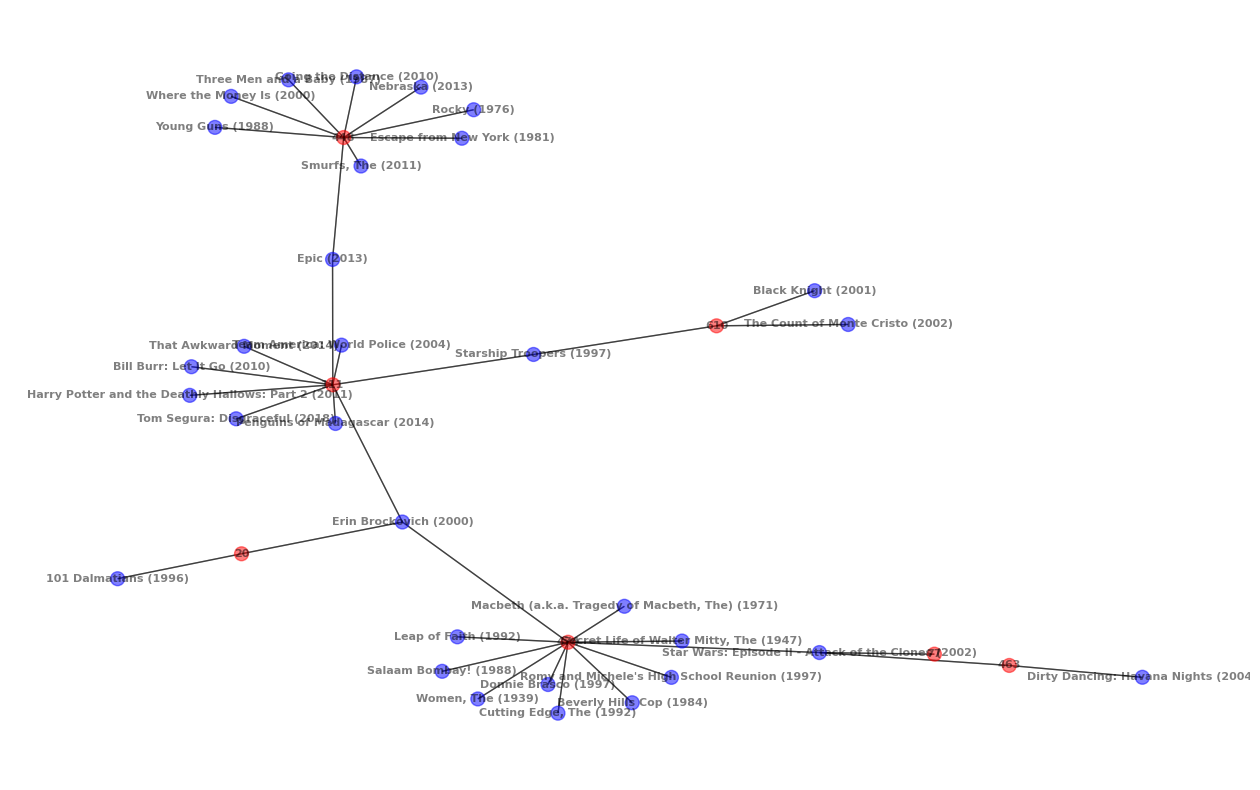

In [12]:
fig, ax = plt.subplots(figsize=(16, 10))

pos = nx.spring_layout(subgraph, seed=42, scale=2)  # Adjust the 'scale' parameter to spread out the graph

# Set node colors
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes]

# Draw the subgraph with smaller nodes, smaller text, and visible edges
nx.draw(subgraph, pos, with_labels=True, font_size=8, font_weight='bold', node_color=node_colors, node_size=100, alpha=0.5)

# Draw edges separately to make them more visible
nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5)

plt.show()

## Colaborative Filtering Matrix

In [13]:
ratings['demeaned_rating'] = ratings["rating"] - 3.5

In [37]:
merged_ratings = pd.merge(ratings, movies, on='movieId', how='inner')
sparse_collabfitering = merged_ratings.pivot(index = "userId", columns ="movieId", values = "demeaned_rating")
sparse_collabfitering.head(10)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.5,NaN,0.5,NaN,NaN,0.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.5,1.5,-0.5,1.5,0.5,0.5,-0.5,NaN,-0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
sparse_collabfitering.to_csv("collbarfilter.csv", index = False)

In [16]:
sparse_matrix = csr_matrix(sparse_collabfitering)

In [17]:
save_npz('collabfiltering.npz', sparse_matrix)

In [18]:
n = len(sparse_collabfitering)

user_similarity = np.zeros((n, n))

In [19]:
for i in tqdm(range(n)):
    user1_movies = sparse_collabfitering.iloc[i, :].notna().to_numpy()
    
    for k in range(i+1, n):
        user2_movies = sparse_collabfitering.iloc[k, :].notna().to_numpy()

        # Calculate intersection using bitwise AND
        intersection_index = user1_movies & user2_movies

        # Check if there are common movies
        if np.sum(intersection_index) >= 10:
            common_movies = sparse_collabfitering.iloc[i, intersection_index].values
            other_user_movies = sparse_collabfitering.iloc[k, intersection_index].values
            
            user_similarity[i, k] = cosine_similarity(common_movies.reshape(1, -1), other_user_movies.reshape(1, -1))[0, 0]
            user_similarity[k, i] = user_similarity[i, k]

100%|██████████| 610/610 [00:24<00:00, 25.04it/s] 


Our cosine similarities are between 0 and 1 becasue ratings can only be positive

In [20]:
user_simDF = pd.DataFrame(user_similarity)
user_simDF.head(20)

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.000000,0.0,0.208093,0.471698,0.103304,0.294579,0.452374,0.000000,0.000000,...,0.892165,0.327916,-0.040260,-0.214286,-0.204685,0.263286,0.303774,-0.049717,0.000000,0.636511
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.438069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.697629
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.208093,0.000000,0.0,0.000000,-0.177705,0.121724,0.543393,0.000000,0.000000,0.000000,...,-0.287261,0.359964,0.105315,0.000000,0.419314,0.119081,0.128295,-0.145913,0.000000,0.029465
4,0.471698,0.000000,0.0,-0.177705,0.000000,0.054133,0.000000,0.039253,0.000000,0.000000,...,0.000000,0.103944,0.212227,0.064062,-0.387768,0.314800,0.202150,-0.071134,0.372104,0.086711
5,0.103304,0.000000,0.0,0.121724,0.054133,0.000000,-0.012793,-0.151163,0.000000,0.000000,...,0.000000,-0.035951,-0.131496,-0.084890,-0.061314,-0.048766,0.371429,0.047110,0.091960,0.176471
6,0.294579,0.000000,0.0,0.543393,0.000000,-0.012793,0.000000,0.000000,0.000000,-0.150025,...,0.177571,0.391862,0.347291,0.000000,0.414873,0.145026,0.462037,0.007372,0.000000,0.234457
7,0.452374,0.000000,0.0,0.000000,0.039253,-0.151163,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.195348,0.229621,0.533363,-0.221470,0.288218,0.377964,0.334324,0.096374,0.316624
8,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.283654,0.000000,0.000000,0.627986,0.000000,0.333050,0.000000,0.679044
9,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.150025,0.000000,0.000000,0.000000,...,-0.305274,0.000000,-0.709736,0.000000,0.246608,-0.490739,0.000000,-0.636523,0.000000,-0.289274


In [34]:
userids = ratings["userId"].unique()
user_simDF.columns = userids
user_simDF.index = userids

In [35]:
user_simDF

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,0.000000,0.000000,0.0,0.208093,0.471698,0.103304,0.294579,0.452374,0.000000,0.000000,...,0.892165,0.327916,-0.040260,-0.214286,-0.204685,0.263286,0.303774,-0.049717,0.000000,0.636511
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.438069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.697629
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.208093,0.000000,0.0,0.000000,-0.177705,0.121724,0.543393,0.000000,0.000000,0.000000,...,-0.287261,0.359964,0.105315,0.000000,0.419314,0.119081,0.128295,-0.145913,0.000000,0.029465
5,0.471698,0.000000,0.0,-0.177705,0.000000,0.054133,0.000000,0.039253,0.000000,0.000000,...,0.000000,0.103944,0.212227,0.064062,-0.387768,0.314800,0.202150,-0.071134,0.372104,0.086711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.263286,0.000000,0.0,0.119081,0.314800,-0.048766,0.145026,0.288218,0.627986,-0.490739,...,0.728722,0.147282,0.308928,0.672450,0.138621,0.000000,0.105613,0.233112,0.471405,0.436794
607,0.303774,0.000000,0.0,0.128295,0.202150,0.371429,0.462037,0.377964,0.000000,0.000000,...,0.912024,0.314316,0.166897,0.099268,-0.229625,0.105613,0.000000,0.100871,-0.174078,0.336302
608,-0.049717,0.000000,0.0,-0.145913,-0.071134,0.047110,0.007372,0.334324,0.333050,-0.636523,...,0.562258,0.287611,0.099716,0.023721,-0.028419,0.233112,0.100871,0.000000,0.584602,0.211834
609,0.000000,0.000000,0.0,0.000000,0.372104,0.091960,0.000000,0.096374,0.000000,0.000000,...,0.000000,0.123731,0.347677,0.173422,0.000000,0.471405,-0.174078,0.584602,0.000000,-0.487088


In [36]:
user_simDF.to_csv("UtU_similarityMatrix_demeaned.csv", index = False)

In [22]:
threshold = 0.8

user_similarity_thresholded = np.where(user_similarity > threshold, 1, 0)
user_similarity_thresholded= pd.DataFrame(user_similarity_thresholded)

In [23]:
user_similarity_thresholded

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
606,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
G = nx.from_pandas_adjacency(user_similarity_thresholded)
print(f"Total Edges: {len(G.edges())}")

Total Edges: 2201


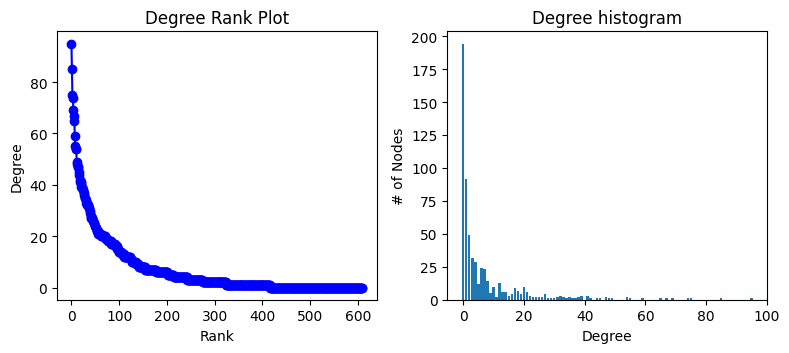

In [25]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [26]:
def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

Creating histogram...


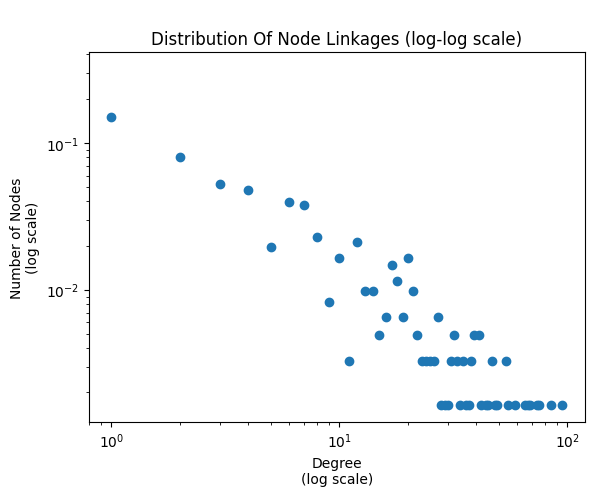

In [27]:
aux_x, aux_y = plot_degree_histogram(G, normalized=True)

plt.title('\nDistribution Of Node Linkages (log-log scale)')
plt.xlabel('Degree\n(log scale)')
plt.ylabel('Number of Nodes\n(log scale)')
plt.xscale("log")
plt.yscale("log")
plt.plot(aux_x, aux_y, 'o')
plt.show()

In [28]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

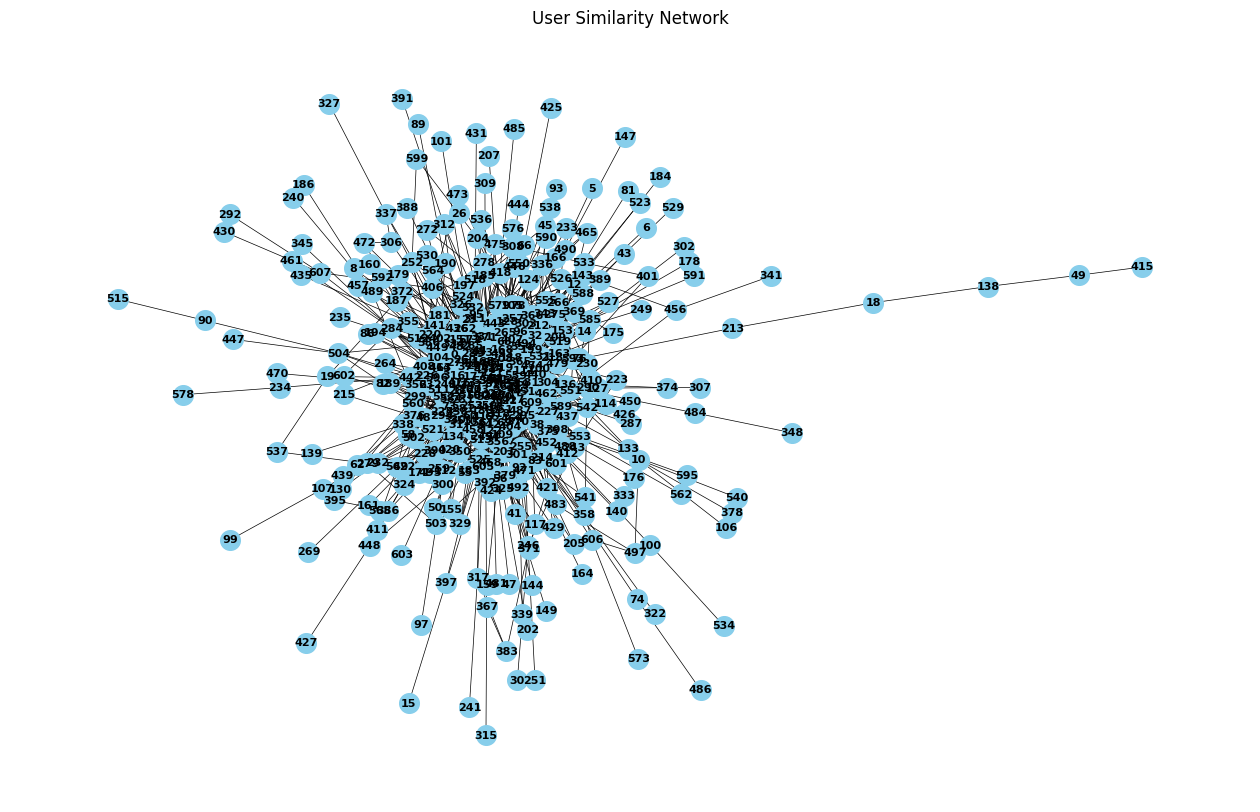

In [29]:
fig, ax = plt.subplots(figsize=(16, 10))
pos = nx.spring_layout(subgraph)

nx.draw(subgraph, pos, with_labels=True, font_weight='bold', node_size=200, node_color='skyblue', font_color='black', font_size=8, edge_color='black', width=0.5)

plt.title("User Similarity Network")
plt.show()